### **Initial Setup**

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [3]:
print(tf.__version__)

2.15.0


### **Importing Image Details (Cars)**

In [4]:
cars_folder = "datasets/Car Counting.v1i.coco/"

In [5]:
from pycocotools.coco import COCO

cars_info_train = cars_folder + "train/_annotations.coco.json"
cars_COCO_train = COCO(cars_info_train)

cars_info_test = cars_folder + "test/_annotations.coco.json"
cars_COCO_test = COCO(cars_info_test)

loading annotations into memory...
Done (t=0.35s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [6]:
imgIds = cars_COCO_train.getImgIds()
print("Total images: {}".format(len(imgIds)))
rand=np.random.randint(0,len(imgIds))
img = cars_COCO_train.loadImgs(imgIds[rand])[0]
print("Image example:")
print(img)
annIds=cars_COCO_train.getAnnIds()
print("\nTotal annotations: {}".format(len(annIds)))
ann=cars_COCO_train.loadAnns(cars_COCO_train.getAnnIds(imgIds=img['id']))
print("Annotation example:")
print(ann[0])

Total images: 5536
Image example:
{'id': 1638, 'license': 1, 'file_name': 'DOH_8_mp4-28_jpg.rf.4cf6c7c3cf27e2538491d472a688e2d5.jpg', 'height': 416, 'width': 416, 'date_captured': '2023-07-16T10:33:59+00:00'}

Total annotations: 31431
Annotation example:
{'id': 9136, 'image_id': 1638, 'category_id': 9, 'bbox': [192, 179, 70.5, 193.5], 'area': 13641.75, 'segmentation': [], 'iscrowd': 0}


In [7]:
car_categories = cars_COCO_train.loadCats(cars_COCO_train.getCatIds())
print("Number of categories: {}".format(len(car_categories)))
cars_kinds = [category['name'] for category in car_categories]
print('\nCOCO categories: \n{}\n'.format(' '.join(cars_kinds)))

Number of categories: 11

COCO categories: 
cc Bus Motorcyecle Pickup SUV Sedan Suv TRUCK TUCK Truck Van



### **Setting Up Dataframes**

In [8]:
ann_ids = cars_COCO_train.getAnnIds()

annotations_list = cars_COCO_train.loadAnns(ann_ids[0:len(ann_ids)])

annotations_df = pd.DataFrame(annotations_list)
annotations_df = annotations_df.drop(["segmentation", "area", "iscrowd"], axis=1)

In [9]:
annotations_df

,id,image_id,category_id,bbox
0,0,0,6,"[102, 150, 35, 43.5]"
1,1,0,5,"[162, 163, 21.5, 24]"
2,2,0,5,"[133, 169, 21.5, 18]"
3,3,0,3,"[147, 223, 35.5, 43]"
4,4,1,9,"[88, 110, 66, 58]"
...,...,...,...,...
31426,31426,5535,5,"[227, 269, 25, 39.5]"
31427,31427,5535,10,"[10, 280, 36.5, 34.5]"
31428,31428,5535,3,"[149, 268, 33, 60.5]"
31429,31429,5535,6,"[10, 303, 38, 42.5]"


In [10]:
image_ids = cars_COCO_train.getImgIds()

image_list = cars_COCO_train.loadImgs(imgIds[0:len(image_ids)])

image_df = pd.DataFrame(image_list)
image_df = image_df.drop(["date_captured", "license"], axis=1)
image_df.rename(columns={'id':'image_id'}, inplace=True)

In [11]:
image_df

,image_id,file_name,height,width
0,0,DOH_10_mp4-5_jpg.rf.1b99964f5eada026f922d24242...,416,416
1,1,DOH--video-converter_com-_mp4-29_jpg.rf.1bb791...,416,416
2,2,DOH_mp4-15_jpg.rf.1bca0d965b9c7bdf418f144f385e...,416,416
3,3,DOH_12_mp4-1_jpg.rf.1bab660cb143eedf004f4f4594...,416,416
4,4,DOH_mp4-13_jpg.rf.1bf23eb96868d1d271d4e44f6229...,416,416
...,...,...,...,...
5531,5531,DOH_4_mp4-18_jpg.rf.9d790097613dad0b42d71db69c...,416,416
5532,5532,DOH_3_mp4-18_jpg.rf.9cf78475ac7f2f6ff2be5381bd...,416,416
5533,5533,DOH_7_mp4-1_jpg.rf.9bb67a2bc97408e3bd27c431bab...,416,416
5534,5534,DOH_3_mp4-18_jpg.rf.9d72f5ebc6892fa37a04bf02c1...,416,416


### **Setting Up Training Data**

In [12]:
image_to_annotations_df = annotations_df["image_id"].value_counts().sort_index().reset_index() # https://stackoverflow.com/questions/35893176/how-to-assign-a-value-count-output-to-a-dataframe
image_to_annotations_df.columns=["image_id", "vehicle_count"]

In [13]:
image_to_annotations_df

,image_id,vehicle_count
0,0,4
1,1,6
2,2,5
3,3,2
4,4,6
...,...,...
5531,5531,3
5532,5532,4
5533,5533,7
5534,5534,5


In [14]:
vehicle_count = [i for i in image_to_annotations_df.vehicle_count]
image_df.insert(4, "vehicle_count", vehicle_count)

In [15]:
image_and_annotations_df = pd.merge(annotations_df, image_df, on="image_id")
image_and_annotations_df.drop(["vehicle_count"], axis=1)

,id,image_id,category_id,bbox,file_name,height,width
0,0,0,6,"[102, 150, 35, 43.5]",DOH_10_mp4-5_jpg.rf.1b99964f5eada026f922d24242...,416,416
1,1,0,5,"[162, 163, 21.5, 24]",DOH_10_mp4-5_jpg.rf.1b99964f5eada026f922d24242...,416,416
2,2,0,5,"[133, 169, 21.5, 18]",DOH_10_mp4-5_jpg.rf.1b99964f5eada026f922d24242...,416,416
3,3,0,3,"[147, 223, 35.5, 43]",DOH_10_mp4-5_jpg.rf.1b99964f5eada026f922d24242...,416,416
4,4,1,9,"[88, 110, 66, 58]",DOH--video-converter_com-_mp4-29_jpg.rf.1bb791...,416,416
...,...,...,...,...,...,...,...
31426,31426,5535,5,"[227, 269, 25, 39.5]",DOH_mp4-15_jpg.rf.9d96ca8d3bcac3594961fc4745d4...,416,416
31427,31427,5535,10,"[10, 280, 36.5, 34.5]",DOH_mp4-15_jpg.rf.9d96ca8d3bcac3594961fc4745d4...,416,416
31428,31428,5535,3,"[149, 268, 33, 60.5]",DOH_mp4-15_jpg.rf.9d96ca8d3bcac3594961fc4745d4...,416,416
31429,31429,5535,6,"[10, 303, 38, 42.5]",DOH_mp4-15_jpg.rf.9d96ca8d3bcac3594961fc4745d4...,416,416


In [27]:
image_and_annotations_df.to_csv("img_ann_noid.csv", index=False)

'id,image_id,category_id,bbox,file_name,height,width,vehicle_count\r\n0,0,6,"[102, 150, 35, 43.5]",DOH_10_mp4-5_jpg.rf.1b99964f5eada026f922d242423833c8.jpg,416,416,4\r\n1,0,5,"[162, 163, 21.5, 24]",DOH_10_mp4-5_jpg.rf.1b99964f5eada026f922d242423833c8.jpg,416,416,4\r\n2,0,5,"[133, 169, 21.5, 18]",DOH_10_mp4-5_jpg.rf.1b99964f5eada026f922d242423833c8.jpg,416,416,4\r\n3,0,3,"[147, 223, 35.5, 43]",DOH_10_mp4-5_jpg.rf.1b99964f5eada026f922d242423833c8.jpg,416,416,4\r\n4,1,9,"[88, 110, 66, 58]",DOH--video-converter_com-_mp4-29_jpg.rf.1bb7916009842fd8b5583a31b81a6ac1.jpg,416,416,6\r\n5,1,3,"[216, 139, 27, 28]",DOH--video-converter_com-_mp4-29_jpg.rf.1bb7916009842fd8b5583a31b81a6ac1.jpg,416,416,6\r\n6,1,5,"[181, 146, 24.5, 34.5]",DOH--video-converter_com-_mp4-29_jpg.rf.1bb7916009842fd8b5583a31b81a6ac1.jpg,416,416,6\r\n7,1,9,"[26, 154, 65, 54]",DOH--video-converter_com-_mp4-29_jpg.rf.1bb7916009842fd8b5583a31b81a6ac1.jpg,416,416,6\r\n8,1,3,"[61, 174, 35.5, 37.5]",DOH--video-converter_com-_mp4-29_j

### **Extracting Cars from Images**

Source: https://www.kaggle.com/code/aryankansal2019/face-mask-detection-classsifier-using-cnn

In [17]:
from PIL import Image

def crop_image(image_path, bbox):
  img = Image.open(image_path)

  left, top, width, height = bbox
  cropped = img.crop((left, top, left + width, top + height))

  return cropped

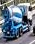

In [18]:
crop_image(cars_folder + "train/DOH_10_mp4-5_jpg.rf.1b99964f5eada026f922d242423833c8.jpg", annotations_df["bbox"][0])

In [19]:
def extract_cars(image_name, dataframe):
  cars_image = []

  df_one_img = dataframe[dataframe['file_name'] == image_name]["bbox"]

  path = cars_folder + "train/" + image_name
  for row in df_one_img:
    img = crop_image(path, row)
    cars_image.append(img)

  return cars_image

In [20]:
for i in extract_cars("DOH_10_mp4-5_jpg.rf.1b99964f5eada026f922d242423833c8.jpg", image_and_annotations_df):
  plt.figure()
  plt.imshow(i)

In [21]:
# Extraction of images is done locally as it takes so long to do in colab

# for arr in cropped_images:
#   for img in arr:
#     height, width = img.height, img.width
#     max_size = max(height, width)
#     r = max_size / 128
#     new_width = int(width / r)
#     new_height = int(height / r)
#     new_size = (new_width, new_height)
#  
#     img = img.resize(new_size, Image.Resampling.LANCZOS)
# 
#     new_img = np.zeros((128, 128, 3), dtype=np.uint8)
#     new_img[0:new_height, 0:new_width] = img
#     new_img = Image.fromarray(new_img)
#     new_img.save(f"extracted_resized_train/{ctr}.jpg")

# extracted_cars = [extract_cars(img, image_and_annotations_df) for img in image_df["file_name"]]
# extracted_cars = sum(extracted_cars, []) # flatten the array

In [22]:
extracted_cars_folder = "datasets/train_2700"

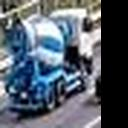

In [23]:
Image.open(extracted_cars_folder + "/0.jpg")

### **Setting Up Model**

In [24]:
import os

img_size = 128

def load_images_from_folder(folder_path):
  images = []
  for filename in os.listdir(folder_path):
    img_path = os.path.join(folder_path, filename)
    image = tf.keras.utils.load_img(img_path)
    images.append(np.asarray(image))
  return images

In [25]:
cars_x_train = np.array(load_images_from_folder(extracted_cars_folder))

KeyboardInterrupt: 

In [ ]:
cars_x_train[0]

array([[[ 98,  98,  90],
        [ 89,  89,  81],
        [ 74,  74,  66],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[ 89,  89,  81],
        [ 80,  80,  72],
        [ 67,  67,  59],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[ 83,  83,  75],
        [ 76,  76,  68],
        [ 64,  64,  56],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[127, 127, 139],
        [128, 128, 140],
        [129, 129, 141],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[132, 134, 146],
        [134, 136, 148],
        [136, 138, 150],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[135, 137, 149],
        [137, 139, 151],
        [139, 141, 153],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

In [ ]:
cars_y_train = annotations_df["category_id"][0:2700]

from tensorflow.keras.utils import to_categorical

cars_y_train = to_categorical(cars_y_train) # change category_id into one-hot encoding

In [ ]:
cars_y_train[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [ ]:
print(cars_x_train.shape)
print(cars_y_train.shape)

(2700, 128, 128, 3)
(2700, 11)


In [ ]:
annotations_df["category_id"].value_counts()

category_id
3     11064
5     10861
9      5266
6      2158
10     1563
2       404
1       115
Name: count, dtype: int64

In [ ]:
img_size = 128
batch_size = 50

input_shape = (img_size, img_size)
output_shape = 11 # how many categories

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

# we have to add some extra layers because
# the input tensor shape at some point during the forward pass of the network became smaller than the filter size (3x3),
# which is causing a negative dimension size. This may be because of the MaxPooling layer being applied too many times or
# the input tensor is too small for the network architecture.
# One possible solution is to add padding to the MaxPooling layers with padding='same' argument.
# This will add zero-padding to the input so that the output size will remain the same.

img_size = 128

model_mobilenet = tf.keras.Sequential([
    hub.KerasLayer('https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/035-128-feature-vector/2',
                  trainable=True, input_shape=(img_size, img_size, 3)),
    tf.keras.layers.Dense(11, activation='softmax'),
])

model_mobilenet.compile(
    optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy','Recall', 'Precision', 'AUC'])

model_mobilenet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1280)              410208    
                                                                 
 dense_2 (Dense)             (None, 11)                14091     
                                                                 
Total params: 424299 (1.62 MB)
Trainable params: 410219 (1.56 MB)
Non-trainable params: 14080 (55.00 KB)
_________________________________________________________________


### **Training the Model**

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((cars_x_train, cars_y_train))
dataset = dataset.batch(batch_size)

for X_batch, y_batch in dataset:
  print(X_batch.shape, y_batch.shape)
  # Train the model on the current batch
  model_mobilenet.fit(x = X_batch, y = y_batch, epochs=10, shuffle=True)  # Adjust epochs as needed

(50, 128, 128, 3) (50, 11)
Epoch 1/10
2/2 [==============================] - 0s 96ms/step - loss: 0.0470 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - auc: 1.0000
Epoch 2/10
2/2 [==============================] - 0s 92ms/step - loss: 0.0472 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - auc: 1.0000
Epoch 3/10
2/2 [==============================] - 0s 93ms/step - loss: 0.0480 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - auc: 1.0000
Epoch 4/10
2/2 [==============================] - 0s 93ms/step - loss: 0.0468 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - auc: 1.0000
Epoch 5/10
2/2 [==============================] - 0s 92ms/step - loss: 0.0475 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - auc: 1.0000
Epoch 6/10
2/2 [==============================] - 0s 95ms/step - loss: 0.0475 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - auc: 1.0000
Epoch 7/10
2/2 [==============================] - 0s 101ms/step - loss: 0.0472 - accu

### **Setting Up Testing Data**

In [ ]:
ann_test_ids = cars_COCO_test.getAnnIds()

annotations_test_list = cars_COCO_test.loadAnns(ann_test_ids[0:len(ann_test_ids)])

annotations_test_df = pd.DataFrame(annotations_test_list)
annotations_test_df = annotations_test_df.drop(["segmentation", "area", "iscrowd"], axis=1)

In [ ]:
annotations_test_df.to_csv("anno_test.csv")

In [ ]:
image_test_ids = cars_COCO_test.getImgIds()

image_test_list = cars_COCO_test.loadImgs(image_test_ids[0:len(image_test_ids)])

image_test_df = pd.DataFrame(image_test_list)
image_test_df = image_test_df.drop(["date_captured", "license"], axis=1)
image_test_df.rename(columns={'id':'image_id'}, inplace=True)

In [ ]:
image_test_df.drop([79]) # note: has no annotations

,image_id,file_name,height,width
0,0,DOH_3--video-converter_com-_mp4-22_jpg.rf.0024...,416,416
1,1,DOH_5_mp4-21_jpg.rf.01da928ef3026555430baae103...,416,416
2,2,DOH_mp4-11_jpg.rf.031038f4fa2f553f73819a0eeaf9...,416,416
3,3,DOH_7_mp4-18_jpg.rf.04a4f1845ce0e6eb1e93ed4167...,416,416
4,4,DOH_14_mp4-16_jpg.rf.0689fe01b6858066de52df93e...,416,416
...,...,...,...,...
286,286,DOH_2--video-converter_com-_mp4-90_jpg.rf.faf2...,416,416
287,287,DOH_17_mp4-7_jpg.rf.f327da2fecade01765216e2d2e...,416,416
288,288,DOH_2_mp4-15_jpg.rf.de3fe6ac1279b91850f1af274b...,416,416
289,289,DOH_mp4-14_jpg.rf.dcf26fd2f070dad798195b78385d...,416,416


In [ ]:
image_to_annotations_test_df = annotations_test_df["image_id"].value_counts().sort_index().reset_index() # https://stackoverflow.com/questions/35893176/how-to-assign-a-value-count-output-to-a-dataframe
image_to_annotations_test_df.columns=["image_id", "vehicle_count"]

In [ ]:
image_to_annotations_test_df

,image_id,vehicle_count
0,0,3
1,1,1
2,2,7
3,3,4
4,4,5
...,...,...
285,286,13
286,287,7
287,288,3
288,289,6


In [ ]:
image_and_annotations_test_df = pd.merge(annotations_test_df, image_test_df, on="image_id")
image_and_annotations_test_df.drop(["category_id"], axis=1)

,id,image_id,bbox,file_name,height,width
0,0,0,"[325, 143, 20.5, 25]",DOH_3--video-converter_com-_mp4-22_jpg.rf.0024...,416,416
1,1,0,"[339, 157, 26.5, 42.5]",DOH_3--video-converter_com-_mp4-22_jpg.rf.0024...,416,416
2,2,0,"[152, 186, 47, 49]",DOH_3--video-converter_com-_mp4-22_jpg.rf.0024...,416,416
3,3,1,"[174, 174, 33, 68.5]",DOH_5_mp4-21_jpg.rf.01da928ef3026555430baae103...,416,416
4,4,2,"[140, 146, 18.5, 27]",DOH_mp4-11_jpg.rf.031038f4fa2f553f73819a0eeaf9...,416,416
...,...,...,...,...,...,...
1668,1668,289,"[1, 220, 42, 49.5]",DOH_mp4-14_jpg.rf.dcf26fd2f070dad798195b78385d...,416,416
1669,1669,289,"[305, 203, 53.5, 106.5]",DOH_mp4-14_jpg.rf.dcf26fd2f070dad798195b78385d...,416,416
1670,1670,290,"[192, 240, 26, 41.5]",DOH_2_mp4-2_jpg.rf.f48953c10f281f6d7a391e834a5...,416,416
1671,1671,290,"[316, 282, 44.5, 56]",DOH_2_mp4-2_jpg.rf.f48953c10f281f6d7a391e834a5...,416,416


### **Testing the Model**

In [ ]:
extracted_cars_test = "datasets/test_300"
cars_x_test = np.array(load_images_from_folder(extracted_cars_test))

In [ ]:
cars_y_test = annotations_test_df["category_id"][0:300]

cars_y_test = to_categorical(cars_y_test) # change category_id into one-hot encoding

In [ ]:
print(cars_x_test.shape)
print(cars_y_test.shape)

(300, 128, 128, 3)
(300, 11)


In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((cars_x_test, cars_y_test))
test_dataset = test_dataset.batch(batch_size)

predictions = []

for X_batch, y_batch in test_dataset:
  # Train the model on the current batch
  predictions.extend(model_mobilenet.predict(x = X_batch))  # Adjust epochs as needed

2/2 [==============================] - 0s 23ms/step


In [ ]:
len(predictions)

300

In [ ]:
predictions

[array([6.6376493e-22, 1.0456035e-07, 1.3908890e-07, 2.3114856e-02,
        8.2990275e-23, 9.2745984e-01, 1.9903919e-03, 5.7008589e-21,
        6.1990122e-24, 8.2714250e-03, 3.9163243e-02], dtype=float32),
 array([1.3330796e-12, 1.8147108e-05, 3.4905266e-04, 8.6723506e-01,
        4.4990942e-13, 3.2311495e-02, 4.5798097e-02, 4.9847028e-12,
        1.9455320e-13, 3.6622647e-02, 1.7665450e-02], dtype=float32),
 array([9.3996156e-12, 3.6189762e-05, 2.1087538e-04, 1.9339979e-02,
        2.8488362e-12, 9.4485587e-01, 1.5749953e-03, 2.7811944e-11,
        6.0847811e-13, 1.1665932e-02, 2.2316065e-02], dtype=float32),
 array([8.4764207e-10, 7.2037027e-04, 1.5457649e-03, 1.8310700e-01,
        3.0924052e-10, 6.8243802e-01, 2.8817106e-02, 2.1756885e-09,
        1.7947104e-10, 6.2868156e-02, 4.0503535e-02], dtype=float32),
 array([2.0954713e-10, 2.0930188e-04, 9.4671844e-04, 7.3617423e-01,
        5.7775972e-11, 2.7868928e-02, 6.0570012e-03, 5.5785304e-10,
        3.1001906e-11, 2.3921819e-03, 2.

In [ ]:
cars_y_test_arr = cars_y_test.tolist()

In [ ]:
cars_y_test_arr

[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.

In [ ]:
len(predictions)

300

In [ ]:
correct_answers = 0

status = {i: [0, 0] for i in range(11)}
answers = [[0 for i in range(11)] for j in range(11)]

for p in range(len(predictions)):
  label_pred = np.max(predictions[p])
  index = np.where(predictions[p] == label_pred)[0]
  
  answer = np.max(cars_y_test_arr[p])
  pred = np.where(cars_y_test_arr[p] == answer)[0]

  answers[index[0]][pred[0]] += 1

  if index == 3 or index == 5:
    if pred == 3 or pred == 5:
      correct_answers += 1
      status[index[0]][0] += 1
  else:
    if index == pred:
      correct_answers += 1
      status[index[0]][0] += 1
    else:
      status[index[0]][1] += 1
    

print("accuracy: ", np.round(correct_answers/len(predictions) * 100, 2), "%", sep = "")

print(status)

for r in answers:
  for c in r:
    print(c, end = "\t")
  print()

accuracy: 69.67%
{0: [0, 0], 1: [0, 0], 2: [0, 0], 3: [100, 0], 4: [0, 0], 5: [109, 0], 6: [0, 5], 7: [0, 0], 8: [0, 0], 9: [0, 3], 10: [0, 9]}
0	0	0	0	0	0	0	0	0	0	0	
0	0	0	0	0	0	0	0	0	0	0	
0	0	0	0	0	0	0	0	0	0	0	
0	3	3	56	0	44	11	0	0	19	6	
0	0	0	0	0	0	0	0	0	0	0	
0	0	4	53	0	56	7	0	0	20	1	
0	0	0	2	0	3	0	0	0	0	0	
0	0	0	0	0	0	0	0	0	0	0	
0	0	0	0	0	0	0	0	0	0	0	
0	0	0	0	0	2	1	0	0	0	0	
0	1	0	4	0	1	1	0	0	2	0	
